# Imports

In [23]:
from catboost import CatBoostClassifier
import emojis as emojis_module
import functools
from imblearn.over_sampling import SMOTE
import matplotlib as mpl
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
import operator
import os.path
import pandas as pd
import re
#import shap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.utils.multiclass import unique_labels
import spacy
import string
import textstat
import time
from tqdm import tqdm
from wordcloud import STOPWORDS, WordCloud

## Tools Initialization

In [24]:
nlp = spacy.load('en_core_web_sm')
porter_stemmer = PorterStemmer()

In [25]:
def init_emojis_category_dict():
    """
    Creates and returns a dictionary containing emojis as keys and their category as values.
    Uses the file 'emoji-test.txt' from Unicode.org available here : https://unicode.org/Public/emoji/12.0/emoji-test.txt.
    """
    emojis_dict = {}
    with open('./data/emoji-test.txt', 'r', encoding='utf-8') as emoji_file:
        raw_subgroups = emoji_file.read().split('# subgroup: ')[1:]
        for raw_subgroup in raw_subgroups:
            raw_subgroup = raw_subgroup.split('\n\n')[0]
            raw_subgroup = raw_subgroup.split('\n')
            subgroup_name = raw_subgroup[0]
            for entry in raw_subgroup[1:-1]:
                try:
                    emojis_dict[re.findall(r'^[\W\d]', entry.split('# ')[1])[0]] = subgroup_name
                except:
                    pass
    return emojis_dict
emojis_category_dict = init_emojis_category_dict()

# Data preprocessing

In [3]:
def read_csv(data_file, separator='\t', header=True, encoding='utf-8'):
    """
    Reads a CSV file then creates and returns a pandas dataframe containing the data. 
    """
    with open(data_file, 'r', encoding=encoding, errors="ignore") as csv_file:
        data = [line.split(separator) for line in csv_file.read().splitlines()]
    data = pd.DataFrame(data[:-1])
    if header:
        header = data.iloc[0]
        data = data[1:]
        data.columns = header
    return data

In [4]:
def load_data():
    """
    Loads the data in a pandas' dataframe and group the tweets by author.
    Returns the dataframe containing following columns : 'doc_id' (int), 'label' (int) and 'content' (str).
    """
    data = pd.DataFrame()
    data_files = ['./data/AMale.txt', './data/AFemale.txt']

    for data_file in data_files:
        data = data.append(read_csv(data_file, separator='\t', header=False, encoding='utf-8'))

    data = data.drop(1, axis='columns') # drop profile's column (human/bot)
    data = data.rename(columns={0: 'doc_id', 2: 'label', 3: 'content'})

    data['doc_id'] = data['doc_id'].apply(lambda x: int(x)) # ids should be integers
    data['label'] = data['label'].apply(lambda gender: 0 if gender == 'M' else 1) # men:0, women:1
    
    # group tweets by author
    data = data.groupby(['doc_id', 'label'])['content'].apply(lambda content_list : " ".join(content_list)).reset_index(name='content')
    
    return data

In [5]:
def preprocess_data(data):
    """
    Applies preprocessing methods on the given dataframe.
    The dataframe must contain following columns :  'doc_id' (int), 'label' (int) and 'content' (str).
    Returns the dataframe.
    """
    # text preprocessing
    data['content'] = data['content'].apply(lambda content: replace_hashtags(replace_mentions(content)))
    
    data['original_content'] = data['content'] # original content shouldn't be changed
    
    data['content'] = data['content'].apply(
        lambda content: stem_sentence(
            re.sub('\s+', ' ', content # remove multiple whitespaces
                #re.sub(r'\b\w{1,3}\b', '', content # remove words of length <= 3
                    .lower() # lower case
                    .translate(content.maketrans('', '', string.punctuation)) # remove punctuation
    ).strip()))
    
    return data

In [6]:
def stem_sentence(sentence):
    """
    Uses an NLTK Porter stemmer to stem the given text.
    Returns a string.
    """
    return ' '.join([porter_stemmer.stem(word) for word in word_tokenize(sentence)])

In [7]:
def string_to_nparray_1d(string_array):
    """
    Converts a list of floats written as a string to a numpy array of floats.
    Example : '[1.1, 2.2]' -> [1.1, 2.2]
    Returns a numpy array of floats.
    """
    #return np.array([value for value in string_array.replace('[', '').replace(']', '').split(', ')]).astype(np.float)
    return np.array([float(value) for value in string_array.replace('[', '').replace(']', '').replace(',', '').split()])

In [8]:
def string_to_nparray_2d(string_array):
    """
    Converts a 2d array written as a string to a list of numpy arrays.
    Example : '[[1.1, 2.2], [3.3, 4.4]]' -> [np.array([1.1, 2.2]), np.array([3.3, 4.4])]
    Returns the list of numpy arrays.
    """
    return np.array([string_to_nparray_1d(array) for array in string_array])

In [9]:
def merge_2d_lists_row_wise(l1, l2):
    """
    Merges row wise two lists of same length.
    Returns the resulting list.
    """
    if len(l1) > 0 and len(l2) > 0:
        #return [[*i, *j] for i, j in zip(l1, l2)]
        return np.concatenate((np.array(l1), np.array(l2)), axis=1).tolist()
    elif len(l1) > 0:
        return l1
    elif len(l2) > 0:
        return l2
    return []

In [10]:
def replace_mentions(text):
    """
    Replaces twitter mentions in the given text by a contant tag.
    Returns the clean text.
    """
    MENTIONS_REPLACEMENT_TAG = "mention"
    MENTIONS_REGEXS = [
        r'(@ [\w\d-]+(( _)|(_ )|( _ )|_)+[\w\d-]+)', # something + _ + something
        r'(@ [\w\d-]+( [\d-]+))', # something + space + numbers
        r'(@ [\w\d-]+)', # something
        ] 

    matches = re.findall('|'.join([f'({regex})' for regex in MENTIONS_REGEXS]), text)
    for tuple_matches in matches:
        if isinstance(tuple_matches, tuple):
            mention = [mention for mention in tuple_matches if len(mention) >= 3][0] # keep the first match which contains at least 3 characters
        else:
            mention = tuple_matches
        text = text.replace(mention, MENTIONS_REPLACEMENT_TAG)
    return text

In [11]:
def replace_hashtags(text):
    """
    Replaces twitter hashtags in the given text by a contant tag.
    Returns the clean text.
    """
    HASHTAGS_REPLACEMENT_TAG = "hashtag"
    HASHTAGS_REGEXS = [
        r'(# [\w\d_-]+( \d+)*)',
        r'(# [\w\d_-]+)',
        ] 

    matches = re.findall('|'.join([f'({regex})' for regex in HASHTAGS_REGEXS]), text)
    for tuple_matches in matches:
        if isinstance(tuple_matches, tuple):
            hashtag = [hashtag for hashtag in tuple_matches if len(hashtag) >= 3][0] # keep the first match which contains at least 3 characters
        else:
            hashtag = tuple_matches
        text = text.replace(hashtag, HASHTAGS_REPLACEMENT_TAG)
    return text

# Dataset statistics

In [12]:
def display_dataset_stats(data):
    """
    Displays statistics for 
    - number of words (min/max/avg)
    - number of characters (min/max/avg)
    - number of documents
    - number of documents written by a man/woman
    """
    #feature_nb_word = (compute_dataframe_features(data, {'nb_words' : True}) if 'nb_words' not in data.columns else data)['nb_words']
    #print(f'Number of words per document. Average : {feature_nb_word.mean()}, Min : {feature_nb_word.min()}, Max : {feature_nb_word.max()}')
    
    #feature_nb_characters = (compute_dataframe_features(data, {'nb_characters' : True}) if 'nb_characters' not in data.columns else data)['nb_characters']
    #print(f'Number of characters per document. Average : {feature_nb_characters.mean()}, Min : {feature_nb_characters.min()}, Max : {feature_nb_characters.max()}')
     
    print(f'Number of documents written by a man : {len([x for x in data["label"] if x == 0])}')
    print(f'Number of documents written by a woman : {len([x for x in data["label"] if x == 1])}')   

# Features

In [13]:
def compute_feature_nb_characters(row):
    """
    Computes the feature nb_character for the given row.
    Return the feature and its length.
    """
    return len(row['content']), 1

In [14]:
def compute_feature_nb_words(row):
    """
    Computes the feature nb_words for the given row.
    Return the feature and its length.
    """
    doc = nlp(row['content'])
    return len(doc), 1

In [15]:
def compute_feature_nb_nouns(row):
    """
    Computes the feature nb_nouns for the given row.
    Return the feature and its length.
    """
    doc = nlp(row['content'])
    return len([token for token in doc if token.pos_ == "NOUN"]), 1

In [16]:
def compute_feature_nb_pronouns(row):
    """
    Computes the feature nb_pronouns for the given row.
    Return the feature and its length.
    """
    doc = nlp(row['content'])
    return len([token for token in doc if token.pos_ == "PRON"]), 1

In [17]:
def compute_feature_nb_digits(row):
    """
    Computes the feature nb_digits for the given row.
    Return the feature and its length.
    """
    return sum(c.isdigit() for c in row['content']), 1

In [18]:
def compute_feature_flesch_readibility(row):
    """
    Computes the feature flesch_readibility for the given row.
    Return the feature and its length.
    """
    return textstat.flesch_reading_ease(row['content']), 1

In [37]:
def compute_feature_nb_emojis(row):
    """
    Computes the feature nb_emojis for the given row.
    Return the feature and its length.
    """
    return emojis_module.count(row['content']), 1

In [38]:
def compute_feature_nb_emojis_per_cat(row):
    """
    Computes the feature nb_emojis_per_cat for the given row.
    Return the feature and its length.
    """
    feature = dict(zip(set(emojis_category_dict.values()), [0 for _ in range(len(set(emojis_category_dict.values())))]))
    for char in emojis_module.get(row['content']):
        if char in emojis_category_dict:
            feature[emojis_category_dict[char]] += row['content'].count(char)
    return list(feature.values()), len(feature.values())

In [39]:
def compute_feature_nb_mentions(row):
    """
    Computes the feature nb_mentions for the given row.
    Return the feature and its length.
    """
    return row['content'].count('mention'), 1

In [40]:
def compute_feature_nb_hashtags(row):
    """
    Computes the feature nb_hashtags for the given row.
    Return the feature and its length.
    """
    return row['content'].count('hashtag'), 1

In [41]:
def compute_feature_nb_urls(row):
    """
    Computes the feature nb_urls for the given row.
    Return the feature and its length.
    """
    return row['content'].count('urllink'), 1

In [42]:
def compute_feature_nb_rts(row):
    """
    Computes the feature nb_rts for the given row.
    Return the feature and its length.
    """
    return row['content'].count('rt'), 1

In [43]:
def compute_feature_nb_big_words(row):
    """
    Computes the feature nb_big_words for the given row.
    Return the feature and its length.
    """
    simple_words_regex = r'\w+'
    long_words_regex = r'^[a-z-]{6,}$'
    long_words = [re.search(long_words_regex, word).group(0) 
                    for word in re.findall(simple_words_regex, row['content']) 
                    if re.search(long_words_regex, word)]
    return len(long_words), 1

In [44]:
def compute_feature_tfidf(training_data, test_data):
    """
    Computes the feature tfidf for the given train and test data..
    Return a list of feature's vectors and the length of a vector.
    """
    vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,2), stop_words='english', min_df=5)
    X_train = vectorizer.fit_transform(training_data['content'].tolist()).toarray()
    X_test = vectorizer.transform(test_data['content'].tolist()).toarray()
    
    features = {index: vector for index, vector in list(zip(training_data.index, X_train)) + list(zip(test_data.index, X_test))}
    features = [vector for _, vector in sorted(features.items())]
    
    return features, len(features[0])

In [45]:
def compute_row_features(row, features_dict):
    """
    Computes the features specified in the given dictionary for the given row.
    Returns a list of new features and a list of their respective length.
    """
    features = []
    features_length = []
    for feature_name, is_feature_used in features_dict.items():
        if is_feature_used:
            if feature_name == 'nb_characters':
                new_feature, new_feature_length = compute_feature_nb_characters(row)
            elif feature_name == 'nb_words':
                new_feature, new_feature_length = compute_feature_nb_words(row)
            elif feature_name == 'nb_nouns':
                new_feature, new_feature_length = compute_feature_nb_nouns(row)
            elif feature_name == 'nb_pronouns':
                new_feature, new_feature_length = compute_feature_nb_pronouns(row)
            elif feature_name == 'nb_digits':
                new_feature, new_feature_length = compute_feature_nb_digits(row)
            elif feature_name == 'flesch_readibility':
                new_feature, new_feature_length = compute_feature_flesch_readibility(row)
            elif feature_name == 'nb_emojis':
                new_feature, new_feature_length = compute_feature_nb_emojis(row)
            elif feature_name == 'nb_emojis_per_cat':
                new_feature, new_feature_length = compute_feature_nb_emojis_per_cat(row)
            elif feature_name == 'nb_mentions':
                new_feature, new_feature_length = compute_feature_nb_mentions(row)
            elif feature_name == 'nb_hashtags':
                new_feature, new_feature_length = compute_feature_nb_hashtags(row)
            elif feature_name == 'nb_urls':
                new_feature, new_feature_length = compute_feature_nb_urls(row)
            elif feature_name == 'nb_rts':
                new_feature, new_feature_length = compute_feature_nb_rts(row)
            elif feature_name == 'nb_big_words':
                new_feature, new_feature_length = compute_feature_nb_big_words(row)
                
            else:
                continue
            if isinstance(new_feature, list):
                features = [*features, *new_feature]
            else:
                features.append(new_feature)
            features_length.append(new_feature_length)
    return features, features_length

In [46]:
def compute_complex_features(data, features_dict, train_indices, test_indices):
    """
    Computes the complex features specified in the given dictionary for the whole dataframe.
    Returns a 2d list containing the new features and a list of their respective length.
    """    
    # identify train and test data
    training_data = data.iloc[train_indices, :]
    test_data = data.iloc[test_indices, :]
    
    # for each complex feature
    features = []
    features_length = []
    for feature_name, is_feature_used in features_dict.items():
        if is_feature_used: 
            if feature_name == 'tfidf':
                new_feature, new_feature_length = compute_feature_tfidf(training_data, test_data)
            else:
                continue
            
            # append the new vectors to the other features (row by row)
            features = merge_2d_lists_row_wise(features, new_feature)
            features_length.append(new_feature_length)
    return features, features_length

In [47]:
def compute_dataframe_features(data, features_dict, train_indices, test_indices, STATIC_BASIC_FEATURES_LIST, STATIC_COMPLEX_FEATURES_LIST):
    """
    Computes the features specified in the given dictionary for the whole dataframe.
    Returns the dataframe containing the computed features.
    """
    all_new_features = []
    features_length, complex_features_length = [], []
    basic_features_dict = set(STATIC_BASIC_FEATURES_LIST).intersection(set(features_dict.keys()))
    basic_features_dict = {feature_name: features_dict[feature_name] for feature_name in basic_features_dict}
    complex_features_dict = set(STATIC_COMPLEX_FEATURES_LIST).intersection(set(features_dict.keys()))
    complex_features_dict = {feature_name: features_dict[feature_name] for feature_name in complex_features_dict}

    # compute basic features (row by row)
    for i, row in data.iterrows():
        computed_features, features_length = compute_row_features(row, basic_features_dict)
        all_new_features.append(computed_features)
    
    # compute complex features (for the whole dataframe)
    complex_computed_features, complex_features_length = compute_complex_features(data, complex_features_dict, train_indices, test_indices)
    
    # merge basic features and complex features
    all_new_features = merge_2d_lists_row_wise(all_new_features, complex_computed_features)
    features_length = features_length + complex_features_length
    
    # save features in the dataframe
    if 'features' in data:
        previous_features = string_to_nparray_2d(data['features'].tolist()).tolist() if isinstance(data['features'][0], str) else data['features'].tolist()
        data['features'] = merge_2d_lists_row_wise(previous_features, all_new_features)
    else:
        data['features'] = all_new_features
    
    # create each feature's own column in the dataframe
    all_new_features = np.swapaxes(np.array(all_new_features), 0, 1)
    i = 0
    for feature_name, is_feature_used in list(basic_features_dict.items()) + list(complex_features_dict.items()):
        if is_feature_used and feature_name not in data: # if feature is used and not already in the dataframe: add its column
            prev = sum(features_length[:i])
            data[feature_name] = list(zip(*all_new_features[prev : prev+features_length[i], ::]))
            i += 1
    return data

In [48]:
def compute_features(data, features, train_indices, test_indices, scaler, STATIC_BASIC_FEATURES_LIST, STATIC_COMPLEX_FEATURES_LIST):
    """
    Computes the features listed in the 'features' dictionary for the given dataframe. 
    Scales the resulting vectors if a scaler has been specified.
    Returns the dataframe, X_train, y_train, X_test, y_test
    """
    data = compute_dataframe_features(data, features, train_indices, test_indices, STATIC_BASIC_FEATURES_LIST, STATIC_COMPLEX_FEATURES_LIST)
    
    X_train = np.array(data.iloc[train_indices, :]['features'].tolist())
    y_train = np.array(data.iloc[train_indices, :]['label'].tolist())
    X_test = np.array(data.iloc[test_indices, :]['features'].tolist())
    y_test = np.array(data.iloc[test_indices, :]['label'].tolist())
    
    # scale data
    if scaler is not None:
        X_train, X_test = scale_data(scaler, X_train, X_test)
        
        scaled_features_col = {index: vector for index, vector in list(zip(train_indices, X_train)) + list(zip(test_indices, X_test))}
        scaled_features_col = [vector for _, vector in sorted(scaled_features_col.items())]
        data = data.assign(scaled_features=pd.Series(scaled_features_col))
        
    return data, X_train, y_train, X_test, y_test

In [49]:
def scale_data(scaler, X_train, X_test):
    """
    Uses a Scikit-Learn scaler to scale the data.
    Returns the scaled X_train and X_test.
    """
    scaler = scaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

# Classification

In [50]:
def train_model(classifier, X_train, y_train, X_test, y_test, params, confusion_matrix=True):
    """
    Initializes an instance of the given classification model with its parameters.
    Trains and evaluates the classifier before returning it with the classification scores.
    """
    model = classifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = [accuracy_score(y_test, y_pred), 
              precision_score(y_test, y_pred, average=None), 
              recall_score(y_test, y_pred, average=None)]
    if confusion_matrix:
        plot_confusion_matrix(y_test, y_pred, np.array(['Man', 'Woman']), normalize=True)
    return model, scores

In [51]:
# Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Data visualization

In [52]:
def plot_data(X_train, y_train, X_test, y_test):
    """
    Uses t-SNE to plot an approximation of the data projected in 2d.
    """
    X_embedded = TSNE(n_components=2).fit_transform(np.concatenate((X_train, X_test)))
    
    category_to_color = {0: 'blue', 1: 'magenta'}
    category_to_label_train = {0: 'Man (training set)', 1: 'Woman (training set)'}
    category_to_label_test = {0: 'Man (test set)', 1: 'Woman (test set)'}
    
    plt.figure(figsize=(10,10))
    for category in category_to_color.keys():
        plt_x_train = [X_embedded[i,0] for i, cat in enumerate(y_train) if cat == category]
        plt_y_train = [X_embedded[i,1] for i, cat in enumerate(y_train) if cat == category]
        
        offset_train = len(X_train)
        plt_x_test = [X_embedded[offset_train+i,0] for i, cat in enumerate(y_test) if cat == category]
        plt_y_test = [X_embedded[offset_train+i,1] for i, cat in enumerate(y_test) if cat == category]
        
        plt.scatter(plt_x_train, plt_y_train, marker='.', color=category_to_color[category], label=category_to_label_train[category], alpha=0.6)
        plt.scatter(plt_x_test, plt_y_test, marker='x', color=category_to_color[category], label=category_to_label_test[category], alpha=0.6)
        plt.legend(loc='best')
    plt.title('Corpus entries\' visualization')
    plt.show()

In [53]:
def plot_wordcloud(text, colormap, collocations=False):
    """
    Plots a wordcloud for the given text.
    """
    stopwords = set(STOPWORDS)
    stopwords.update(['hashtag', 'mention', 'urllink', 'rt'])
    wordcloud = WordCloud(stopwords=stopwords, collocations=collocations, 
                          background_color="white", colormap=colormap, 
                          width=1920, height=1080)
    wordcloud = wordcloud.generate(text)
    plt.figure(num=None, figsize=(9, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
    plt.axis("off")
    plt.show()

# Constants

In [63]:
# define constants here...

# data
LOAD_DATA_FROM_CSV = True
RECOMPUTE_FEATURES = True
SAVE_AFTER_RECOMPUTING_FEATURES = False
DATA_PKL_FILE = './data/basic_7_standardsc_35.pkl'

# features
FEATURES = {
    'nb_characters':      True, #
    'nb_words':           True, #
    'nb_nouns':           True, #
    'nb_pronouns':        True, #
    'nb_digits':          True, #
    'flesch_readibility': True, #
    'nb_emojis':          True, #
    'nb_emojis_per_cat':  True, #
    
    'nb_lexical_words':   False,
    
    'nb_mentions':        False,
    'nb_hashtags':        False,
    'nb_urls':            False,
    'nb_rts':             False,
    'nb_big_words':       False,
    
    'tfidf':              False,
}

# models
CLASSIFIER = CatBoostClassifier # [CatBoostClassifier]
SCALER = StandardScaler # [None, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler]

# models' parameters
PARAMS = {
    CatBoostClassifier: {
        'iterations':200, 
        'depth':6, 
        'learning_rate':0.2, 
        'loss_function':'CrossEntropy', 
        'custom_metric':['Accuracy', 'Recall', 'Precision'], 
        'verbose':False},
}
GRIDSEARCH_PARAMS_RANGE = {
    CatBoostClassifier: {
        'loss_function': ['Logloss', 'CrossEntropy'],
        'iterations': [250,100,500,1000],
        'depth': [3,1,2,6,4,5,7,8,9,10],
        'learning_rate': [0.03,0.001,0.01,0.1,0.2,0.3], 
    }
}

# training
GRIDSEARCH_NB_CV_SPLITS = 2
TEST_SIZE = 0.35

# ---- constants' validity check
DATA_CSV_STATIC_COLUMNS = ['doc_id', 'label', 'content', 'original_content', 'train_entry', 'features']
STATIC_BASIC_FEATURES_LIST = [
    'nb_characters', 'nb_words', 'nb_nouns', 'nb_pronouns', 'nb_digits', 'nb_mentions', 'nb_hashtags', 'nb_urls', 'nb_rts', 
    'nb_emojis', 'nb_emojis_per_cat', 'nb_big_words', 'nb_lexical_words', 'flesch_readibility']
STATIC_COMPLEX_FEATURES_LIST = ['tfidf']
assert all([feature in STATIC_BASIC_FEATURES_LIST+STATIC_COMPLEX_FEATURES_LIST for feature in FEATURES.keys()])
assert GRIDSEARCH_NB_CV_SPLITS > 1
assert CLASSIFIER in [CatBoostClassifier]
assert SCALER in [None, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler]
assert TEST_SIZE > 0.0 and TEST_SIZE < 1.0

# Main

In [64]:
# load the data
if LOAD_DATA_FROM_CSV and os.path.isfile(DATA_PKL_FILE):
    data = pd.read_pickle(DATA_PKL_FILE)
    features_column = 'scaled_features' if 'scaled_features' in data else 'features'
    train_entries = data.loc[data['train_entry'] == 1]
    test_entries = data.loc[data['train_entry'] == 0]
    X_train = train_entries[features_column].tolist()
    y_train = train_entries['label'].tolist()
    X_test = test_entries[features_column].tolist()
    y_test = test_entries['label'].tolist()
    
else:
    if LOAD_DATA_FROM_CSV:
        print(f'Can\'t load data from CSV. File does not exist: {DATA_CSV_FILE}\nCreating dataset...')
    data = load_data()
    data = preprocess_data(data)
    
    # split train/test sets
    train_indices, test_indices = next(StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE).split(data, np.array(data['label'].tolist())))
    data['train_entry'] = [1 if i in train_indices else 0 for i in data.index] # train:1, test:0

    # compute features
    data, X_train, y_train, X_test, y_test = compute_features(data, FEATURES, train_indices, test_indices, SCALER, STATIC_BASIC_FEATURES_LIST, STATIC_COMPLEX_FEATURES_LIST)
        
    # export the dataset as CSV
    data.to_pickle(DATA_PKL_FILE)
print('Dataset loaded!')

Dataset loaded!


In [65]:
# compute more features
if LOAD_DATA_FROM_CSV and os.path.isfile(DATA_PKL_FILE) and RECOMPUTE_FEATURES:
    precomputed_features_name = [col_name for col_name in data.columns if col_name not in DATA_CSV_STATIC_COLUMNS]
    features_to_compute = {feature_name: is_feature_used for feature_name, is_feature_used in FEATURES.items() 
                           if feature_name not in precomputed_features_name and is_feature_used}

    train_indices = [i for i in data.index if data.iloc[i, :]['train_entry'] == 1]
    test_indices = [i for i in data.index if data.iloc[i, :]['train_entry'] == 0]
    data, X_train, y_train, X_test, y_test = compute_features(data, features_to_compute, train_indices, test_indices, SCALER, STATIC_BASIC_FEATURES_LIST, STATIC_COMPLEX_FEATURES_LIST)
    
    # export the dataset as CSV
    if SAVE_AFTER_RECOMPUTING_FEATURES:
        data.to_pickle(DATA_PKL_FILE)
    
    print(f'New features computed and dataset saved: {list(features_to_compute.keys())}.')

New features computed and dataset saved: ['nb_emojis_per_cat'].


In [66]:
# display dataset info
display_dataset_stats(data)
print('Shape of the dataframe :', data.shape)
print('Size of the features\' vectors :', len(string_to_nparray_1d(data.iloc[0,:]['features'])) if isinstance(data.iloc[0,:]['features'], str) else len(data.iloc[0,:]['features']))
data.head()

Number of documents written by a man : 1030
Number of documents written by a woman : 1030
Shape of the dataframe : (2060, 15)
Size of the features' vectors : 103


,doc_id,label,content,original_content,train_entry,features,nb_nouns,nb_characters,nb_words,flesch_readibility,nb_emojis,nb_pronouns,nb_digits,scaled_features,nb_emojis_per_cat
0,0,1,alex is too nice for love island rt mention te...,alex is too nice for love island :( rt mentio...,1,"[408.0, 5656.0, 1234.0, -1120.81, 64.0, 81.0, ...","(408.0,)","(5656.0,)","(1234.0,)","(-1120.81,)","(64.0,)","(81.0,)","(27.0,)","[-1.204728693488203, -1.2743310760208904, -1.0...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,1,rt mention the crypto financ ecosystem by ment...,rt mention : the crypto finance ecosystem by m...,0,"[716.0, 9912.0, 1902.0, -1840.11, 1.0, 102.0, ...","(716.0,)","(9912.0,)","(1902.0,)","(-1840.11,)","(1.0,)","(102.0,)","(70.0,)","[0.8965027085555635, 0.7382696239503245, 0.569...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,5,1,mention mention mention mention x i fuck love ...,mention mention !!!!! mention mention x i fu...,1,"[399.0, 5160.0, 1126.0, -1000.37, 77.0, 79.0, ...","(399.0,)","(5160.0,)","(1126.0,)","(-1000.37,)","(77.0,)","(79.0,)","(39.0,)","[-1.2661283123790923, -1.5088822854160318, -1....","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,6,0,mention ahaha last time act reckless 😂😂 mentio...,mention ahaha last time acting reckless 😂😂 me...,0,"[299.0, 4403.0, 1006.0, -788.23, 196.0, 77.0, ...","(299.0,)","(4403.0,)","(1006.0,)","(-788.23,)","(196.0,)","(77.0,)","(15.0,)","[-1.9483463000556398, -1.8668566110453104, -1....","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,8,1,i m so excit for the boojum i m about to get i...,i ' m so excited for the boojum i ' m about to...,1,"[409.0, 7151.0, 1600.0, -1509.56, 16.0, 201.0,...","(409.0,)","(7151.0,)","(1600.0,)","(-1509.56,)","(16.0,)","(201.0,)","(27.0,)","[-1.1979065136114375, -0.5673672493157761, -0....","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


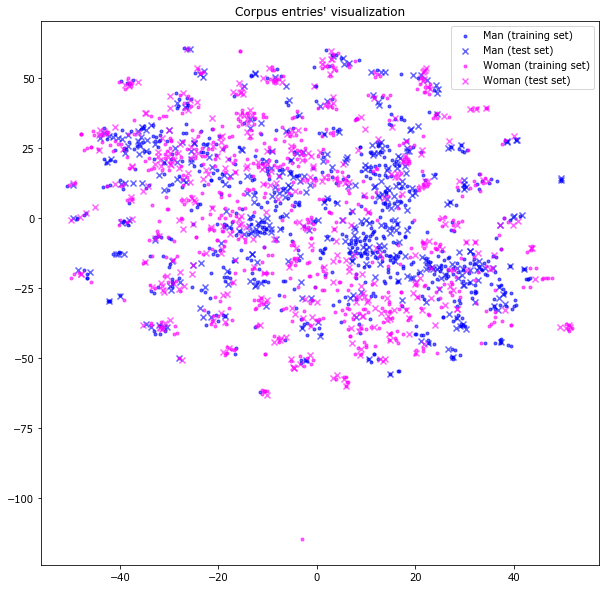

In [67]:
# t-SNE
plot_data(X_train, y_train, X_test, y_test)

Men's tweets :


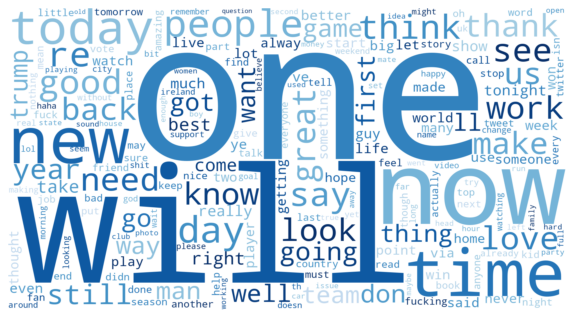

Women's tweets :


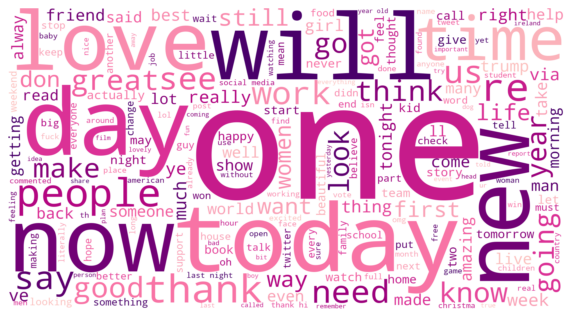

In [60]:
# wordcloud
print('Men\'s tweets :')
men_cmap = mpl.colors.ListedColormap(mpl.cm.Blues(np.linspace(0, 1, 20))[5:,:-1])
plot_wordcloud(' '.join(list(data.loc[data['label'] == 0]['original_content'])), men_cmap, collocations=True)
print('Women\'s tweets :')
women_cmap = mpl.colors.ListedColormap(mpl.cm.RdPu(np.linspace(0, 1, 20))[5:,:-1])
plot_wordcloud(' '.join(list(data.loc[data['label'] == 1]['original_content'])), women_cmap, collocations=True)

In [100]:
# gridsearch
clf = GridSearchCV(CLASSIFIER(), GRIDSEARCH_PARAMS_RANGE[CLASSIFIER], cv=GRIDSEARCH_NB_CV_SPLITS)
clf.fit(X_train, y_train)
print(f'Best classification score: {clf.best_score_}')
print(f'Best parameters: {clf.best_params_}')

NameError: name 'X' is not defined

Time to train the classifier: 0.1 m


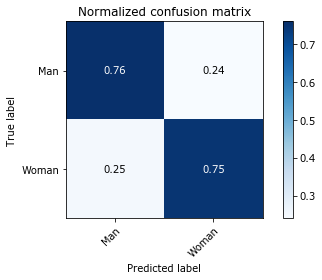

In [68]:
# training
start_time = time.time()
model, scores = train_model(CLASSIFIER, X_train, y_train, X_test, y_test, PARAMS[CLASSIFIER])
print(f'Time to train the classifier: {round((time.time()-start_time)/60, 1)} m')

In [69]:
# metrics
try:
    models_and_scores
except:
    models_and_scores = None
if True: #not isinstance(models_and_scores, pd.DataFrame)
    models_and_scores = pd.DataFrame([np.array([model, scores])], columns=['Model', 'Scores'])
    models_and_scores['Accuracy'] = models_and_scores['Scores'].apply(lambda scores: scores[0])
    models_and_scores['Precision'] = models_and_scores['Scores'].apply(lambda scores: scores[1])
    models_and_scores['Recall'] = models_and_scores['Scores'].apply(lambda scores: scores[2])
    models_and_scores = models_and_scores.drop('Scores', axis='columns')

print('Mean accuracy: {:.3f}'.format(models_and_scores["Accuracy"].mean()))
models_and_scores.head()

Mean accuracy: 0.753


,Model,Accuracy,Precision,Recall
0,<catboost.core.CatBoostClassifier object at 0x...,0.753121,"[0.7506849315068493, 0.7556179775280899]","[0.7590027700831025, 0.7472222222222222]"
